# Методология ведения DS-проектов

# 1. Понимаение бизнеса

## 1.1. Цель

Определить качество вина по его физико-химическому составу

## 1.2. Описание 

Из-за неразглашения данных или проблем логистики у вина известны только его физико-химический состав и вкусовые качества. Необходимо классифицировать вино по качеству от 0 до 10.

# 2. Data Understanding

## 2.1. Import libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

from sklearn.metrics import confusion_matrix
import shap

from imblearn.over_sampling import RandomOverSampler

## 2.2. Загрузка данных 

In [ ]:
data = pd.read_csv('https://drive.google.com/uc?id=1nTxKlnlXwBEGFJ-iaxF3lZX0FP2FZKWd&export=download')

## 2.3. Статистика и визуализация

In [ ]:
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Описание переменных**

* type - тип вина (белое\красное)
* fixed acidity - фиксированная кислотность
* volatile acidity - переменная кислотность
* citric acid - цитрусовая кислотность
* residual sugar - остаточный сахар
* chlorides - хлориды
* free sulfur dioxide - свободный диоксид серы
* total sulfur dioxide - общий диоксид серы
* density - плотность
* pH
* sulphates - сульфаты
* alcohol - алкоголь

Целевая перменная:
* quality (оценка от 0 до 10)



### 2.3.1. Взглянем на ключевую информацию о переменных

In [ ]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Видим, что датасет имеет пропуски, т.к. их количество составляет менее 5% от датасета, удалим их в дальнейшем

### 2.3.2. Тепловая карта корреляции 

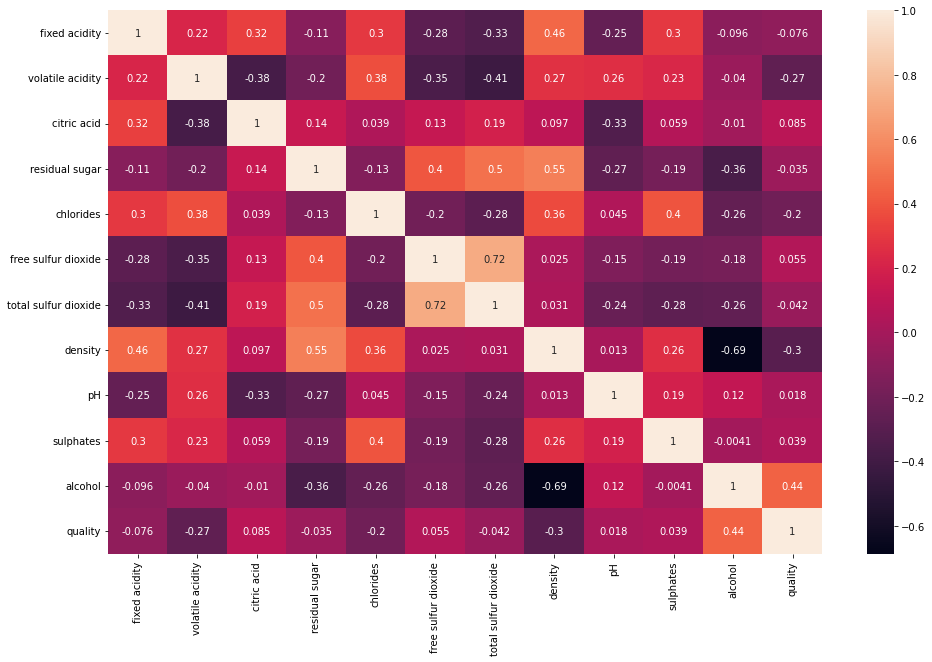

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10)) 
sns.heatmap(data.corr(), annot=True, ax=ax)

Больше всего на качество влияют алкоголь, кислотность, плотность и хлориды. Также видим высокую корреляцию между многими переменными, например между общим количеством оксидов серы и свободными количеством

### 2.3.3. Рассмотрим взаимосвязь между признаками и качеством

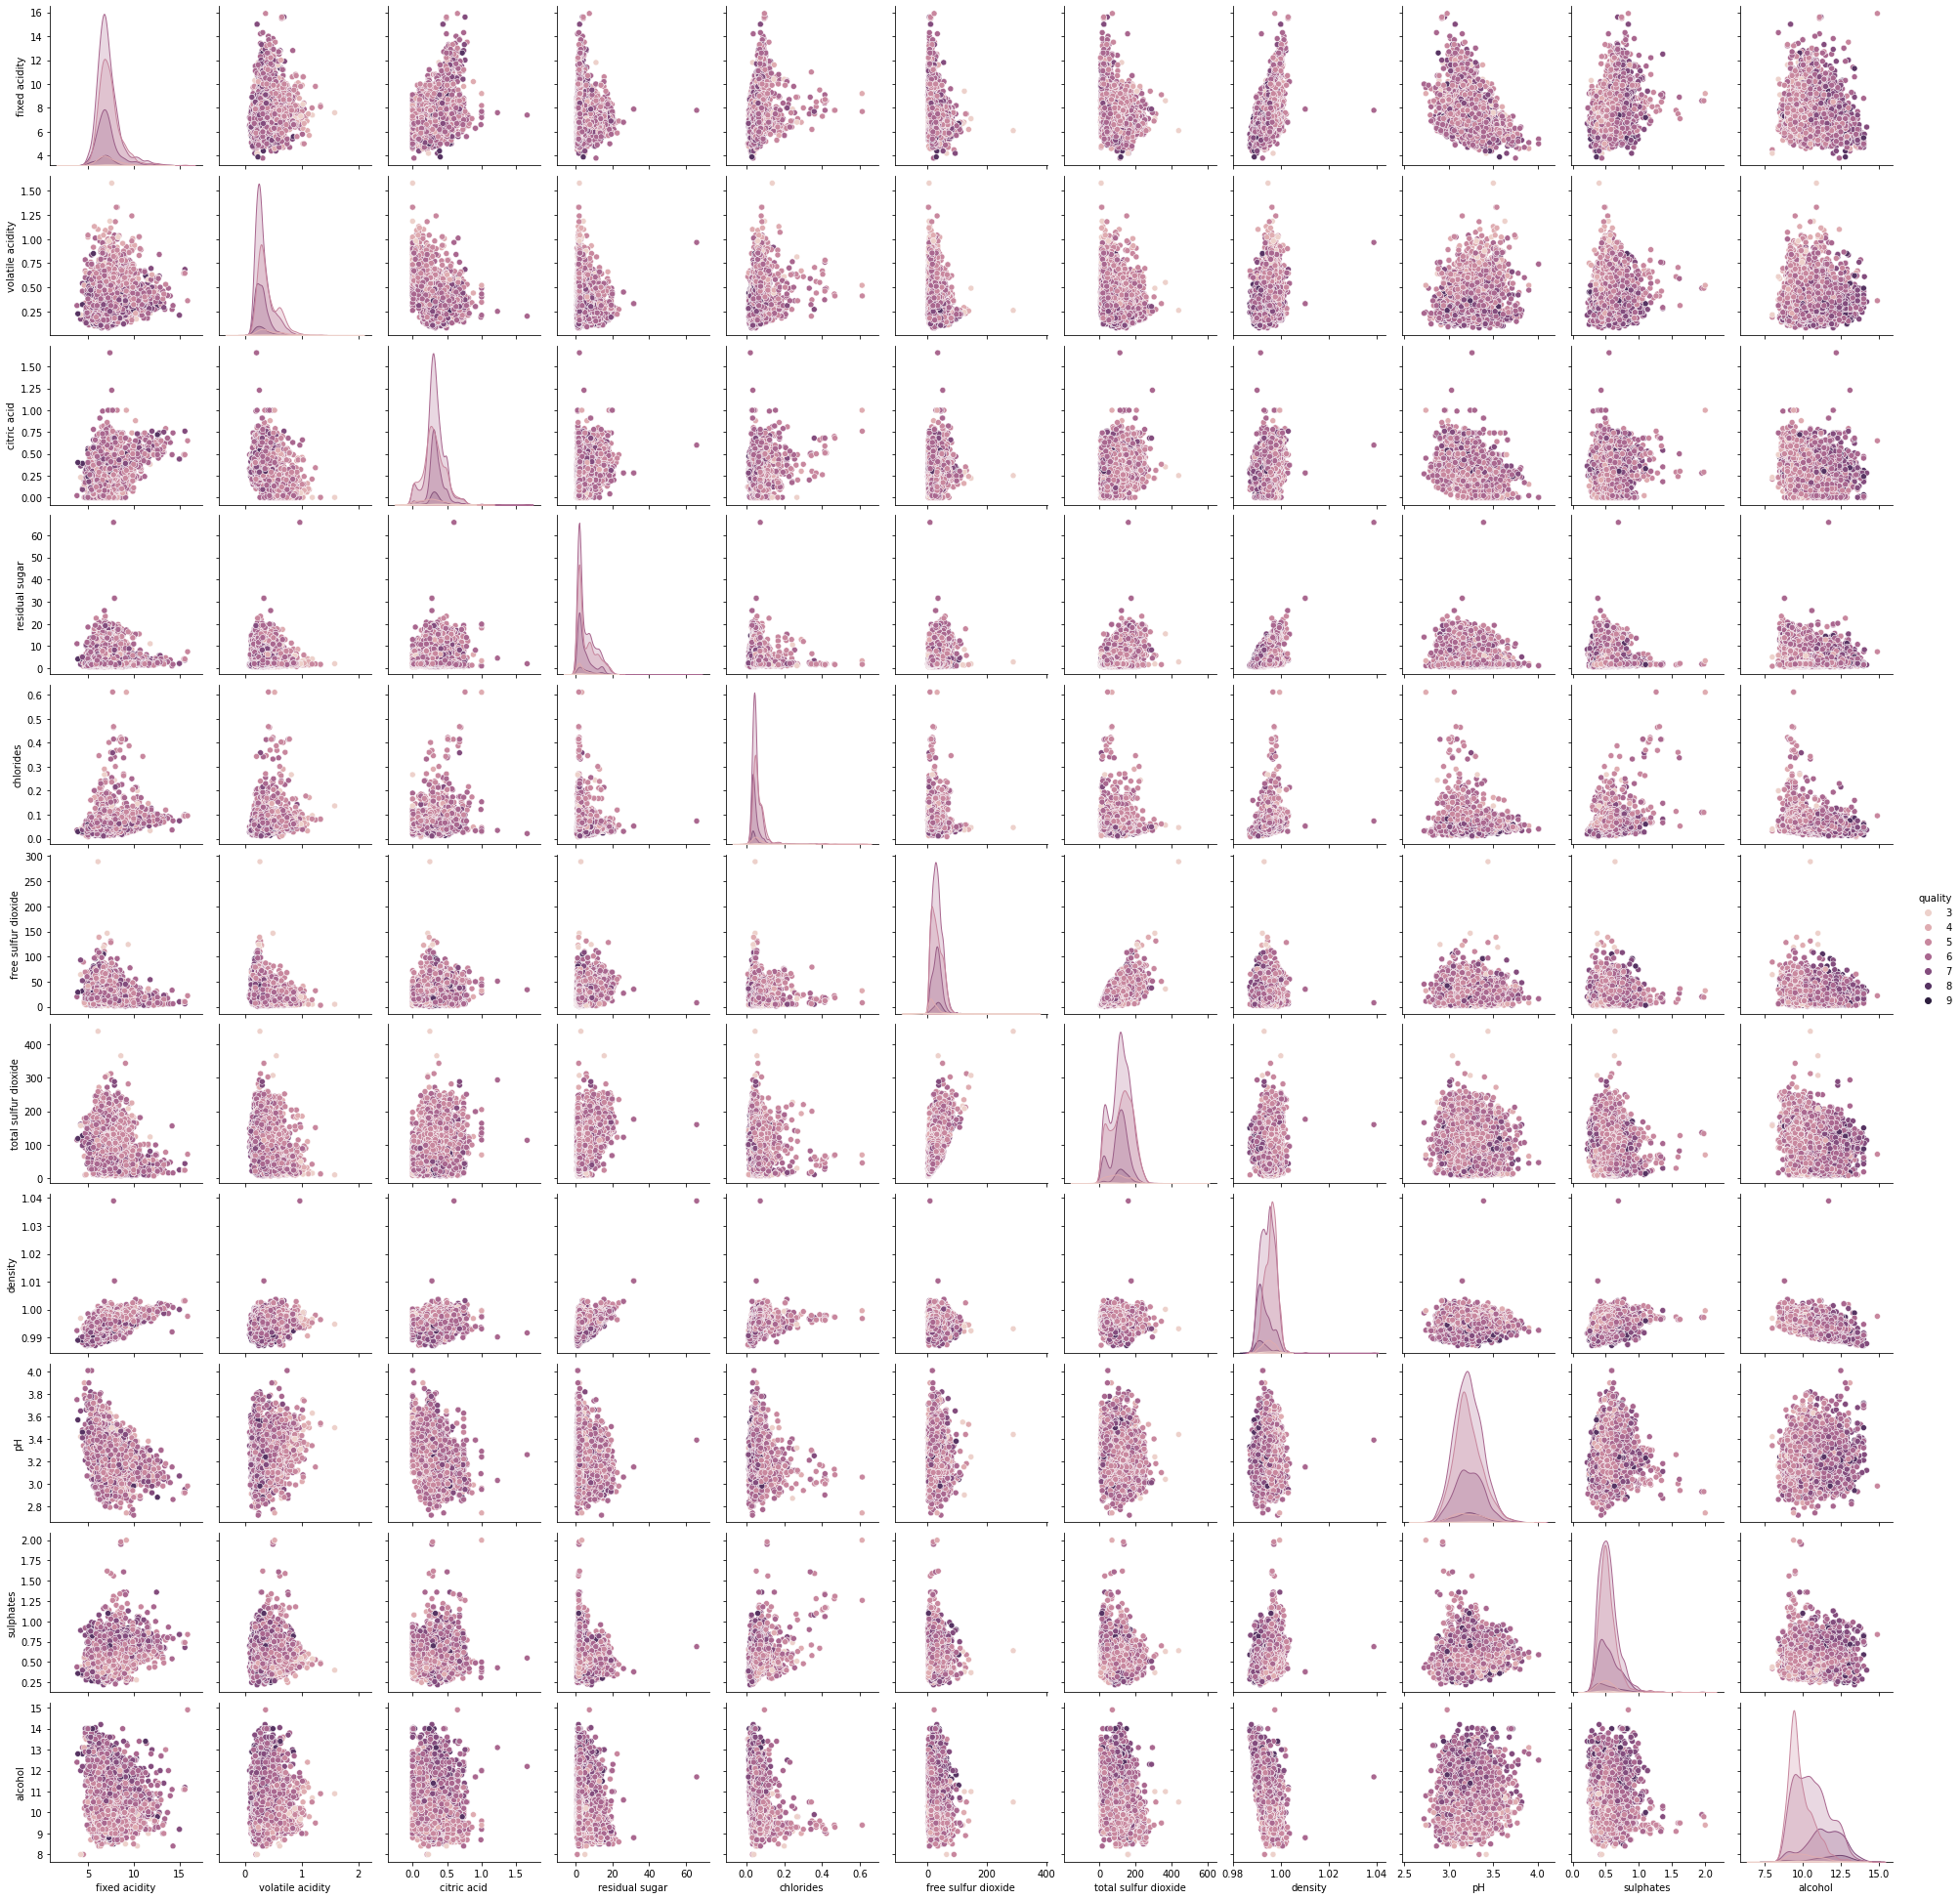

In [ ]:
sns.pairplot(data, hue='quality')

На диагрммах видно гистограммы распредления переменных + выделение некоторых классов вин. 

## 2.3.4 Посмотрим на распредление классов по датасету

<BarContainer object of 7 artists>

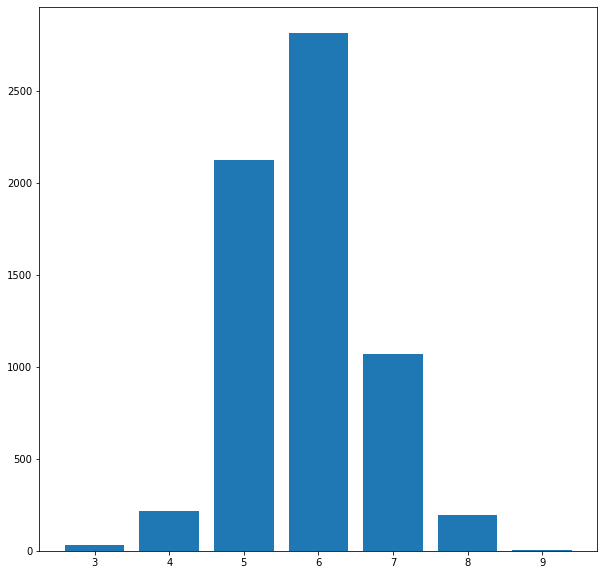

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10)) 
ax.bar(sorted(data['quality'].unique()), data.groupby('quality').size())

Видим малое количество примеров для 3 и 9 классов

# 3. Data preparation

## 3.1. Удаляем пропуски

In [ ]:
data = data.dropna()

## 3.2. Кодирование категориальных перменных

Закодируем тип вина как категориальную переменную

In [ ]:
data = pd.get_dummies(data, columns=['type'])

## 3.3. Работа с выбросами

Поищем выбросы автоматически

In [ ]:
data['lof'] = LocalOutlierFactor().fit_predict(data)
data['isol'] = IsolationForest().fit_predict(data)
data['env'] = EllipticEnvelope().fit_predict(data)
data['svm'] = OneClassSVM().fit_predict(data)
data['anomaly'] = data['lof'] + data['isol'] + data['env'] + data['svm']

In [ ]:
data[data['anomaly'] == -4]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white,lof,isol,env,svm,anomaly
2781,7.8,0.965,0.60,65.8,0.074,8.0,160.0,1.03898,3.39,0.69,11.7,6,0,1,-1,-1,-1,-1,-4
5340,15.6,0.685,0.76,3.7,0.100,6.0,43.0,1.00320,2.95,0.68,11.2,7,1,0,-1,-1,-1,-1,-4
5436,12.9,0.350,0.49,5.8,0.066,5.0,35.0,1.00140,3.20,0.66,12.0,7,1,0,-1,-1,-1,-1,-4
5550,15.9,0.360,0.65,7.5,0.096,22.0,71.0,0.99760,2.98,0.84,14.9,5,1,0,-1,-1,-1,-1,-4
5671,7.9,0.400,0.29,1.8,0.157,1.0,44.0,0.99730,3.30,0.92,9.5,6,1,0,-1,-1,-1,-1,-4
5672,7.9,0.400,0.30,1.8,0.157,2.0,45.0,0.99727,3.31,0.91,9.5,6,1,0,-1,-1,-1,-1,-4
5809,9.1,0.280,0.46,9.0,0.114,3.0,9.0,0.99901,3.18,0.60,10.9,6,1,0,-1,-1,-1,-1,-4
6084,6.6,0.800,0.03,7.8,0.079,6.0,12.0,0.99630,3.52,0.50,12.2,5,1,0,-1,-1,-1,-1,-4
6332,10.2,0.540,0.37,15.4,0.214,55.0,95.0,1.00369,3.18,0.77,9.0,6,1,0,-1,-1,-1,-1,-4
6333,10.2,0.540,0.37,15.4,0.214,55.0,95.0,1.00369,3.18,0.77,9.0,6,1,0,-1,-1,-1,-1,-4


Удалим эти выбросы

In [ ]:
data = data[data['anomaly'] != -4]
data = data.drop(columns=['anomaly', 'lof', 'isol', 'env', 'svm'])

## 3.4. Сборка финального датасета

### 3.4.1. Работа с признаками

На основе свободных диокидов серы и общего количества можем осздать признак процентного содержания свободных диокисдов серы 

In [ ]:
data['free sulfur dioxide, %'] = data['free sulfur dioxide'] / data['total sulfur dioxide']
data = data.drop(columns=['free sulfur dioxide', 'total sulfur dioxide'])

### 3.4.2. Посмотрим на важность признаков для предсказания

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[[c for c in data.columns if c != 'quality']], data['quality'], test_size=0.2, random_state=12) 
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
rf.score(X_test, y_test)

0.6886134779240899

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_value = explainer(X_train)

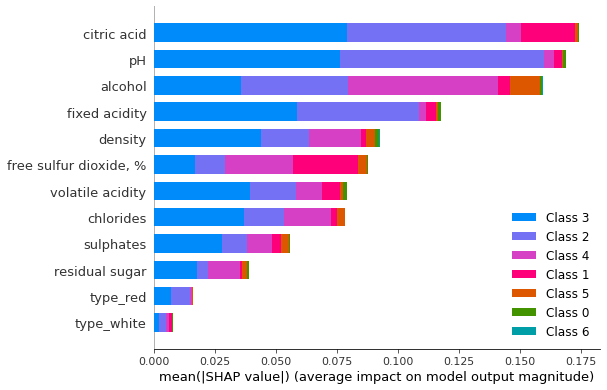

In [ ]:
choosen_instance = X_train.loc[[1]]
shap_values = explainer.shap_values(choosen_instance)
shap.summary_plot(shap_values, X_train)

Видим, какие признаки наиболее авктивно участвуют в выявлении разных классов, можно удалить признаки типизации вина

In [ ]:
data = data.drop(columns=['type_red', 'type_white'])

Так же необходимо разделить данные на тестовую и обучающую выборки и при этом воспользоваться разделением по стратам

In [ ]:
columns = [c for c in data.columns if c != 'quality'];
X = data[columns]
y = data['quality']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for trn_idx, tst_idx in sss.split(X, y):
  X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
  X_test, y_test = X.iloc[tst_idx], y.iloc[tst_idx]

Так же на обучающей выборке сделаем оверсемплинг

In [ ]:
ros = RandomOverSampler(random_state=78)
X_train, y_train = ros.fit_resample(X_train, y_train)

# 4. Моделирование

## 4.1. Выбор модели

Выше мы обучали случайный лес для отбора признаков. Для финального моделирования выберем логистическую регрессию и посмотрим на её характеристики

In [ ]:
model = LogisticRegression(max_iter=1000)

## 4.2. Обучение модели

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = model.score(X_train, y_train)
print(score)

0.48048486387002604


Точность получилась неудовлетворительной, попробуем обучить случайный лес на этих данных

In [ ]:
model = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=23)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = model.score(X_train, y_train)
print(score)

0.9884495779653487


# 5. Оценка модели

Можем оценить точность модели и узнавание классов, проверив её на валидационных данных

In [ ]:
score = model.score(X_test, y_test)
print(score)
print(confusion_matrix(y_test, y_pred))

0.6491092176607282
[[  0   1   3   2   0   0   0]
 [  2   8  16  16   1   0   0]
 [  0   7 307  99  12   0   0]
 [  0   3 116 369  75   0   0]
 [  0   1   8  63 139   4   0]
 [  0   0   0   7  16  15   0]
 [  0   0   0   0   1   0   0]]


Допустим, бизнес устраивает данное решение, модель путается в средних винах 5-7, но в целом показывает хороший результат

# 6. Развертывание

В данном случае развертывание означает отправку данного ноутбука на проверку.